In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm_notebook
from nltk.corpus import wordnet as wn

SEED = 42
EPS = 1e-5
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

target = wn.synset('mammal.n.01')
words = wn.words()

In [ ]:
nouns = set()
for word in words:
    nouns.update(wn.synsets(word, pos='n'))

print(len(nouns), 'nouns')

hypernyms = []
for noun in nouns:
    paths = noun.hypernym_paths()
    for path in paths:
        try:
            pos = path.index(target)
            for i in range(pos, len(path)-1):
                hypernyms.append((noun, path[i]))
        except Exception:
            continue
            
hypernyms = np.array(list(set(hypernyms)))
uniq_hypernyms = np.array(list(set([e for tup in hypernyms for e in tup])))

word2idx = {val: i for i, val in enumerate(uniq_hypernyms)}
random.shuffle(hypernyms)

print(len(hypernyms), 'hypernyms' )

In [8]:
def proj(params):
    norm = params.norm(p=2, dim=1).unsqueeze(1)
    norm[norm < 1] = 1+EPS
    params = params.div(norm)-EPS
    return params

def arcosh(x):
    return torch.log(x + torch.sqrt(x**2 - 1))

def distance(u, v):
    uu = u.norm(dim=1)**2
    vv = v.norm(dim=1)**2
    uv = u.mm(v.t())
    alpha = 1-uu
    alpha = alpha.clamp(min=EPS)
    beta = 1-vv
    beta = beta.clamp(min=EPS)
    
    gamma = 1 + 2 * (uu - 2 * uv + vv) / (alpha * beta)
    gamma = gamma.clamp(min=1+EPS)
    
    return arcosh(gamma)
def plot():
    lhds, rhds = hypernyms[:, 0], hypernyms[:, 1]

    targets = set(lhd for i, lhd in enumerate(lhds) if rhds[i] == target)
    embeddings = EMBEDDINGS.numpy()

    if len(targets) + 1 > 30:
        targets = random.sample(targets, 30-1)
    targets.append(target)
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.cla() # clear things for fresh plot

    ax.set_xlim((-1.1, 1.1))
    ax.set_ylim((-1.1, 1.1))

    circle = plt.Circle((0,0), 1., color='black', fill=False)
    ax.add_artist(circle)

    for n in targets:
        x, y = embeddings[word2idx[n]]
        ax.plot(x, y, 'o', color='y')
        ax.text(x+0.01, y+0.01, n, color='b')
    plt.show()

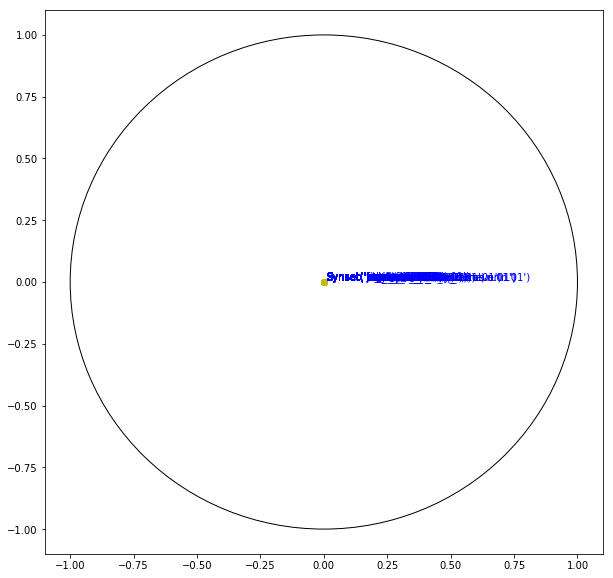

/usr/lib/python3.6/site-packages/torch/tensor.py:306: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.sub_(other)


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



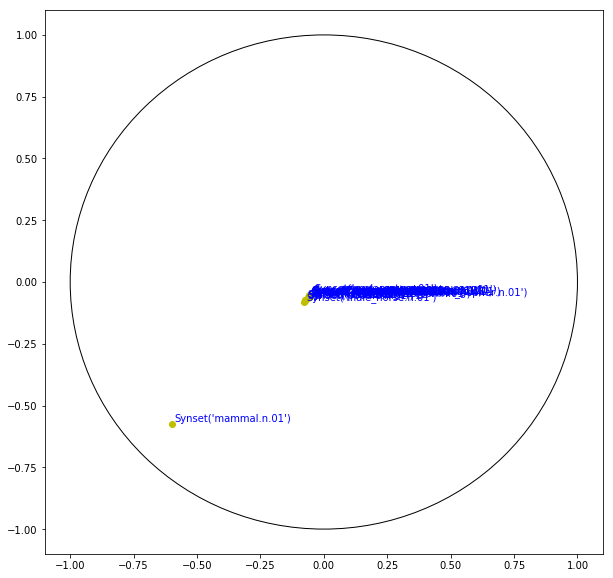

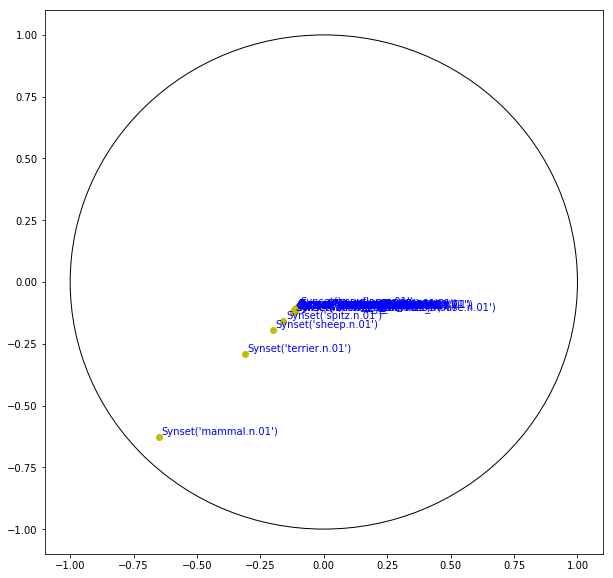

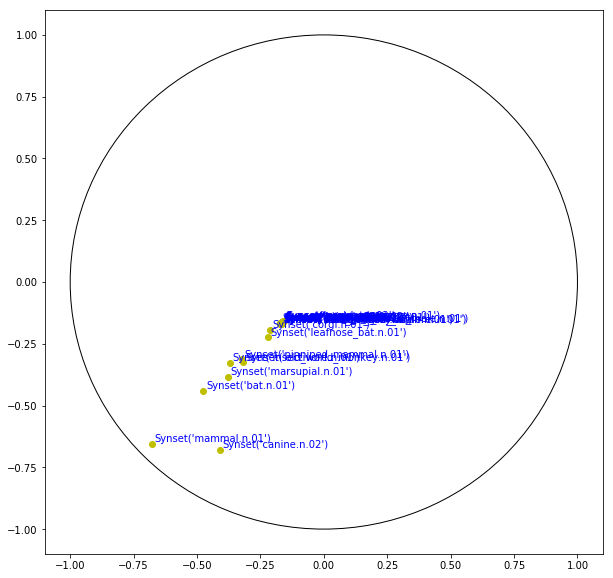

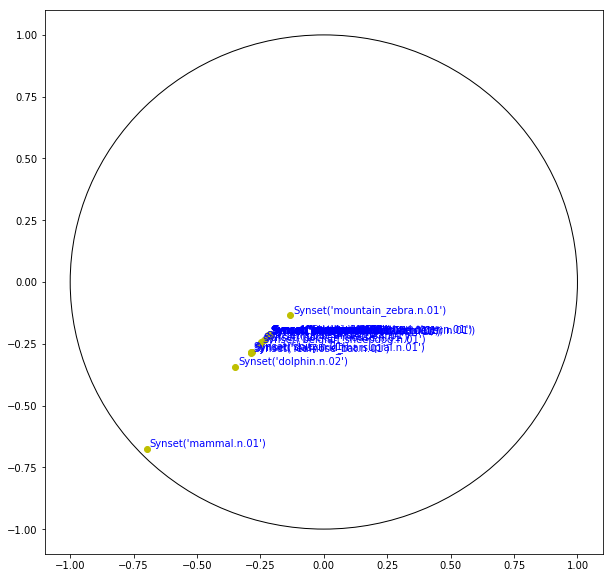

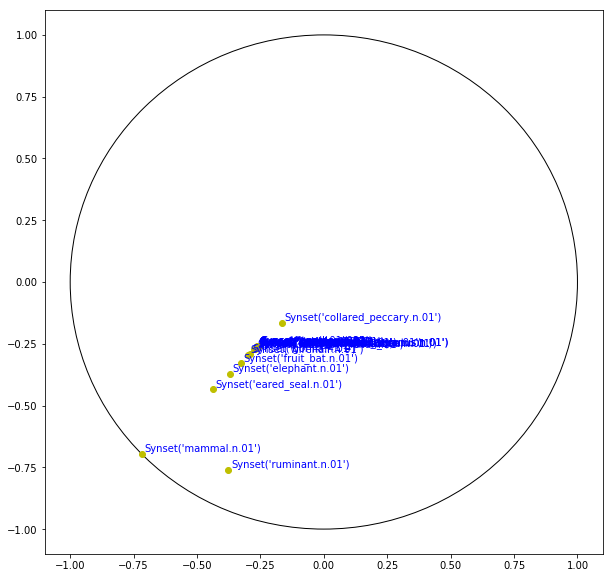

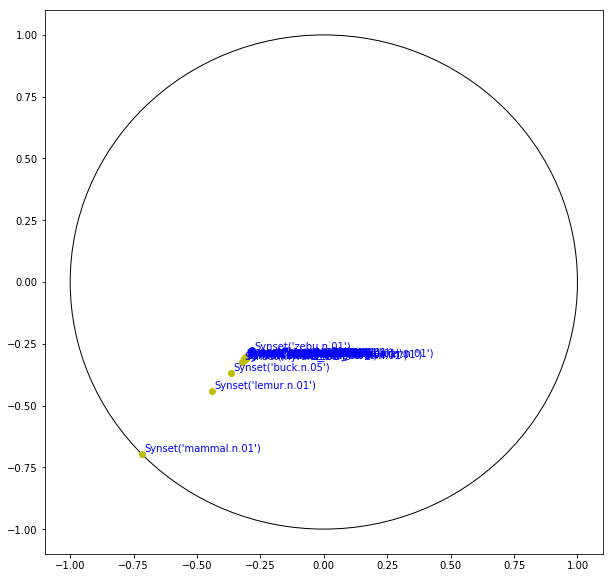

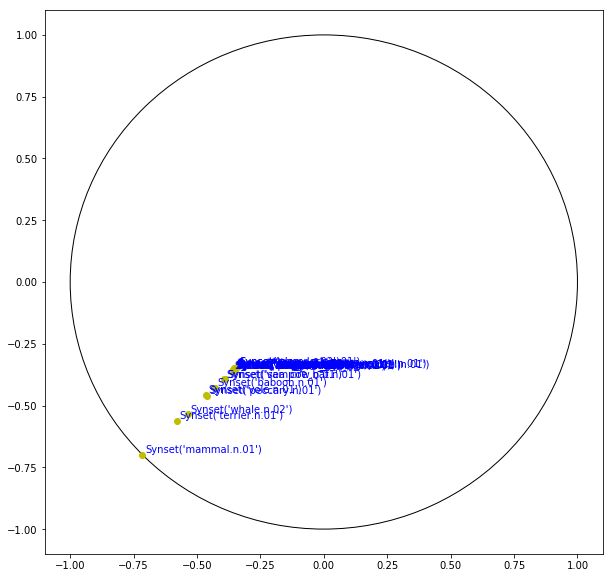

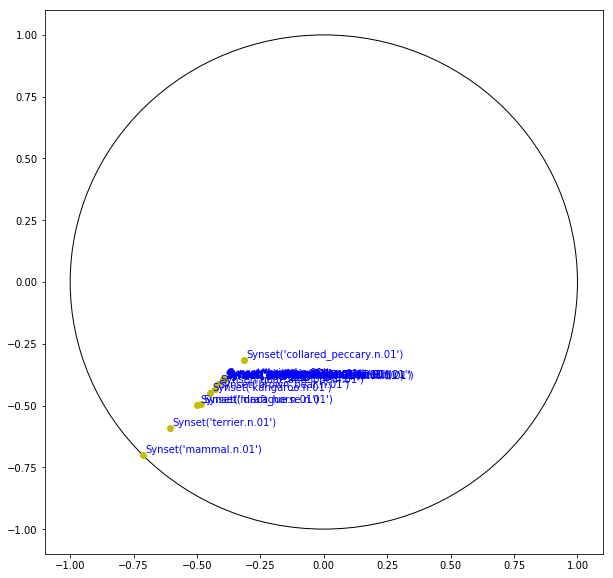

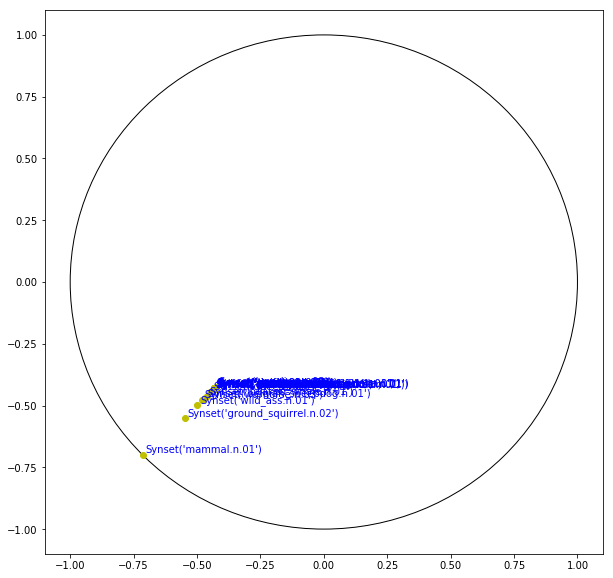

In [9]:
EPOCHS = 10
DIM = 2
START_LR = 0.1
FINAL_LR = 0.0001
NEG = 10

EMBEDDINGS = torch.Tensor(len(uniq_hypernyms), DIM)
nn.init.uniform(EMBEDDINGS, a=-0.001, b=0.001)

NEG_SAMPLES = torch.from_numpy(np.random.randint(0, len(uniq_hypernyms), size=(EPOCHS, len(hypernyms), NEG)))

bar1 = tqdm_notebook(range(EPOCHS))
for epoch in bar1:
    plot()
    bar2 = tqdm_notebook(hypernyms, leave=False)
    for i, (w1, w2) in enumerate(bar2):
        i_w1 = word2idx[w1]
        i_w2 = word2idx[w2]
        u = Variable(EMBEDDINGS[i_w1].unsqueeze(0), requires_grad=True)
        v = Variable(EMBEDDINGS[i_w2].unsqueeze(0), requires_grad=True)
        negs = Variable(EMBEDDINGS[NEG_SAMPLES[epoch, i]], requires_grad=True)
        
        loss = torch.exp(-1*distance(u, v)) / torch.exp(-1*distance(u, negs)).sum()
        bar2.set_postfix(loss=loss.data[0, 0])
        loss.backward()
        
        r = epoch/EPOCHS
        LR = (1-r) * START_LR + r * FINAL_LR
        EMBEDDINGS[NEG_SAMPLES[epoch, i]] -= LR * (((1-negs.norm(dim=1)**2) ** 2) / 4).data.unsqueeze(1) * negs.grad.data
        EMBEDDINGS[i_w1] -= LR * (((1-u.norm()**2) **2) / 4).data * u.grad.data
        EMBEDDINGS[i_w2] -= LR * (((1-v.norm()**2) **2) / 4).data * v.grad.data
        
        EMBEDDINGS = proj(EMBEDDINGS)